# Using Corelle in Python

**Daven Quinn**, University of Wisconsin, September 2020

In [1]:
%matplotlib inline

## A basic map using CartoPy

In [2]:
import cartopy
import matplotlib.pyplot as P

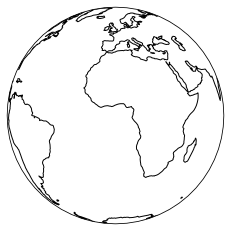

In [3]:
# Make sure we can plot a simple map with CartoPy
ortho = cartopy.crs.Orthographic()
fig = P.figure()
ax = fig.add_subplot(projection=ortho)
ax.coastlines()
fig.show()

## Adding plate polygons from Corelle

The first step in using the Corelle plate-rotation system is to get modern plate polygons. Later, we will rotate these back in time dynamically using quaternion rotation vectors provided separately.

The Corelle API returns GeoJSON-formatted plate polygons with information on the valid age range for each plate encoded in the `old_lim` and `young_lim` properties.

In [4]:
from requests import get
res = get("https://birdnest.geology.wisc.edu/corelle/api/plates?model=Wright2013")
plate_features = res.json()

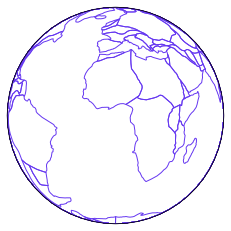

In [5]:
from shapely.geometry import shape

fig = P.figure()
ax = fig.add_subplot(projection=ortho)

geometries = [shape(f["geometry"]) for f in plate_features]
ax.add_geometries(geometries, crs=cartopy.crs.Geodetic(), edgecolor="#6638f0", facecolor='none')
fig.show()

## Adding pre-split feature layers

Corelle keeps some basic feature layers on the server, pre-split for each plate model. A list of the options can be found at the [root of the API route](https://birdnest.geology.wisc.edu/corelle/api/feature). More feature types can be added easily.

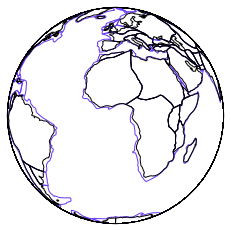

In [6]:
# API call returns GeoJSON format plates

coast_features = get("https://birdnest.geology.wisc.edu/corelle/api/feature/ne_110m_land?model=Wright2013").json()
geometries = [shape(f["geometry"]) for f in coast_features]
ax.add_geometries(geometries, crs=cartopy.crs.Geodetic(), edgecolor="black", facecolor="none")
fig

### The structure of a plate feature

In [7]:
plate_features[0]

{'id': 202,
 'properties': {'id': 4217,
  'plate_id': 202,
  'young_lim': 0,
  'old_lim': 600.0,
  'name': 'Parana Basin Plate, South America'},
 'type': 'Feature',
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[-54.3065697309999, -39.9785525659999],
     [-54.6479925589999, -40.312862418],
     [-62.2591400839999, -39.8864822829999],
     [-64.0420537629999, -39.4994955179999],
     [-64.2533767059999, -39.1296721709999],
     [-64.3400300739999, -37.3497015449999],
     [-64.0804546319999, -33.574621352],
     [-64.2536545009999, -32.1676300409999],
     [-63.8209610189999, -27.402604832],
     [-57.1066539129999, -29.6706413749999],
     [-55.1404348959999, -30.1981507899999],
     [-49.0062320319999, -31.7093648879999],
     [-51.7864551179999, -36.6206338939999],
     [-53.0331075599999, -38.0013349839999],
     [-53.5290875629999, -38.9932949909999],
     [-54.3065697309999, -39.9785525659999]]]]}}

# Applying rotations

## Get and apply rotations at 90 Ma

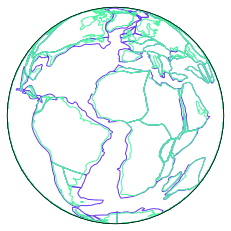

In [8]:
from corelle_helpers import rotate_features, rotate_geometry
import numpy as N
rotations = get("https://birdnest.geology.wisc.edu/corelle/api/rotate?model=Wright2013&time=90&quaternion=true").json()



fig = P.figure()
ax = fig.add_subplot(projection=ortho)

# Rotate our plate polygons
feat = list(rotate_features(rotations, plate_features))
ax.add_geometries(feat, crs=cartopy.crs.Geodetic(), edgecolor="#6638f0", facecolor='none')

# Rotate our coastline features
feat = list(rotate_features(rotations, coast_features))
ax.add_geometries(feat, crs=cartopy.crs.Geodetic(), edgecolor="#4af2a1", facecolor="none")
fig.show()

# A rotation time series

Here, we will try to use bulk rotation of features to build a global paleolatitude time series.

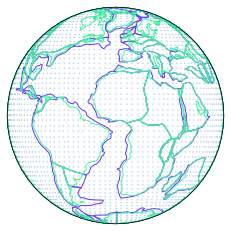

In [9]:
from geom_helpers import points_on_sphere
from shapely.geometry import Point

# Plot a (nearly) uniform distribution of points on a sphere
pt = points_on_sphere(5000)
ax.plot(pt[:, 0], pt[:, 1], "o", markersize=0.2, transform=cartopy.crs.Geodetic(), rasterized=True)
fig

Working in Python allows us to use high-level functions to accomplish GIS tasks, so we use the [spatial-intersection functionality in GeoPandas](https://geopandas.org/set_operations.html) to figure out the plate for each tracer point.

In [10]:
# Use GeoPandas to match features
import geopandas
from shapely.geometry import Point
from geopandas import GeoDataFrame, GeoSeries, overlay
# Construct a GeoDataFrame from our uniform points
series = GeoSeries([Point(p[0],p[1]) for p in pt])
tracers = GeoDataFrame({"geometry": series})
tracers.index.name = "tracer_id"
tracers[:10]

,geometry
tracer_id,
0,POINT (0 88.57142857142858)
1,POINT (120 88.57142857142858)
2,POINT (-120 88.57142857142858)
3,POINT (0 85.71428571428572)
4,POINT (39.99999999999999 85.71428571428572)
5,POINT (80 85.71428571428572)
6,POINT (120 85.71428571428572)
7,POINT (160 85.71428571428572)
8,POINT (-160 85.71428571428572)


In [11]:
plates = GeoDataFrame.from_features(plate_features)
plates[:10]

,geometry,id,name,old_lim,plate_id,young_lim
0,(POLYGON ((-54.3065697309999 -39.9785525659999...,4217,"Parana Basin Plate, South America",600.0,202,0.0
1,"(POLYGON ((131.256438242 42.294640164, 130.210...",4178,North China,600.0,604,0.0
2,"(POLYGON ((-5.36976009399996 44.822788518, -3....",4179,Iberia,600.0,304,0.0
3,"(POLYGON ((-51.7854473929999 83.2100825630001,...",4180,Canadian Arctic Islands,600.0,106,0.0
4,"(POLYGON ((35.7585905220001 33.8153430630001, ...",4181,"Sinai, Africa",600.0,508,0.0
5,"(POLYGON ((99.794006145 42.3711897140001, 101....",4182,North China,195.0,604,0.0
6,"(POLYGON ((-136.646193681 57.0700114040002, -1...",4183,Accreted Terrane,145.0,126,0.0
7,"(POLYGON ((-139.734134357011 61.7992831639785,...",4184,North Slope Alaska,245.0,125,0.0
8,"(POLYGON ((104.899209233 6.04983777400014, 104...",4185,Malay Peninsula,600.0,619,0.0
9,"(POLYGON ((-130.388449914005 53.7950044679774,...",4186,Accreted Terrane,245.0,128,0.0


In [12]:
# Note: `rtree` module must be installed
# This function classifies all points by their overlapping (modern) plates
res_intersection = overlay(tracers.reset_index(), plates, how='identity')
# Get non-null rows
plate_tracers = res_intersection[res_intersection.plate_id.notnull()]
plate_tracers[:10]

,tracer_id,id,name,old_lim,plate_id,young_lim,geometry
0,24.0,4180.0,Canadian Arctic Islands,600.0,106.0,0.0,POINT (-90.00000000000001 82.85714285714286)
1,25.0,4180.0,Canadian Arctic Islands,600.0,106.0,0.0,POINT (-67.49999999999999 82.85714285714286)
2,44.0,4180.0,Canadian Arctic Islands,600.0,106.0,0.0,POINT (-98.18181818181819 80.00000000000001)
3,45.0,4180.0,Canadian Arctic Islands,600.0,106.0,0.0,POINT (-81.81818181818184 80)
4,69.0,4180.0,Canadian Arctic Islands,600.0,106.0,0.0,POINT (-115.7142857142857 77.14285714285714)
5,70.0,4180.0,Canadian Arctic Islands,600.0,106.0,0.0,POINT (-102.8571428571429 77.14285714285714)
6,71.0,4180.0,Canadian Arctic Islands,600.0,106.0,0.0,POINT (-90.00000000000001 77.14285714285714)
7,72.0,4180.0,Canadian Arctic Islands,600.0,106.0,0.0,POINT (-77.14285714285721 77.14285714285714)
8,102.0,4180.0,Canadian Arctic Islands,600.0,106.0,0.0,POINT (-105.8823529411765 74.28571428571429)
9,103.0,4180.0,Canadian Arctic Islands,600.0,106.0,0.0,POINT (-95.29411764705883 74.28571428571429)


In [13]:
from corelle_helpers import rotate_dataframe

rotated_tracers = rotate_dataframe(plate_tracers, rotations, 90)

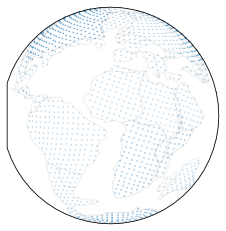

In [14]:
fig = P.figure()
ax = fig.add_subplot(projection=ortho)

# Also rotate the plate polygon
rotated_plates = rotate_dataframe(plates, rotations, time=90)
ax.add_geometries(rotated_plates.geometry, crs=cartopy.crs.Geodetic(), edgecolor="#eeeeee", facecolor='none')

ax.plot(rotated_tracers.geometry.x, rotated_tracers.geometry.y, "o", markersize=0.2, transform=cartopy.crs.Geodetic(), rasterized=True)
fig.show()

In [15]:
# Get rotations through time (every 1 Myr from 540 Ma to present).
## This takes a (relatively) long time and returns 4 MB of data! It may be worth caching the results locally
## (they are already cached on the server)
res = get("https://birdnest.geology.wisc.edu/corelle/api/rotate-series", params={
    "model": "Wright2013",
    "time_start": 540,
    "time_end": 0,
    "interval": 10,
    "quaternion": True
}).json()

In [16]:
from pandas import concat

all_tracers = (rotate_dataframe(plate_tracers.copy(), **tstep) for tstep in res)
tracers_time = concat(all_tracers)

In [17]:
# Get rid of tracers that are too old for their plates
df = tracers_time[tracers_time.time <= tracers_time.old_lim]

In [18]:
df

,tracer_id,id,name,old_lim,plate_id,young_lim,geometry,time
0,24.0,4180.0,Canadian Arctic Islands,600.0,106.0,0.0,POINT (-127.1579326494431 -10.32680980025652),540.0
1,25.0,4180.0,Canadian Arctic Islands,600.0,106.0,0.0,POINT (-125.1137276600776 -12.25309711974548),540.0
2,44.0,4180.0,Canadian Arctic Islands,600.0,106.0,0.0,POINT (-130.2849193905407 -10.72068100543809),540.0
3,45.0,4180.0,Canadian Arctic Islands,600.0,106.0,0.0,POINT (-128.6521981943141 -13.05924939846678),540.0
4,69.0,4180.0,Canadian Arctic Islands,600.0,106.0,0.0,POINT (-134.0580090794829 -8.248903742492473),540.0
5,70.0,4180.0,Canadian Arctic Islands,600.0,106.0,0.0,POINT (-133.3266328679169 -11.01165454423925),540.0
6,71.0,4180.0,Canadian Arctic Islands,600.0,106.0,0.0,POINT (-131.9833015378707 -13.54740583282033),540.0
7,72.0,4180.0,Canadian Arctic Islands,600.0,106.0,0.0,POINT (-130.0750124814305 -15.72549767449297),540.0
8,102.0,4180.0,Canadian Arctic Islands,600.0,106.0,0.0,POINT (-136.3258206623441 -11.24621141957022),540.0
9,103.0,4180.0,Canadian Arctic Islands,600.0,106.0,0.0,POINT (-135.1950949379693 -13.88901413545986),540.0


In [19]:
df["latitude"] = df.geometry.apply(lambda d: d.y)

g = df.sort_values("time").groupby("plate_id")

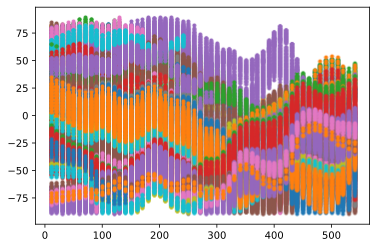

In [22]:
fig = P.figure()
ax = fig.add_subplot()
for ix, gp in g:
    ax.plot(gp["time"], gp["latitude"], '.', rasterized=True)
fig.show()